## Titanic: Machine Learning from disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [12]:
# packages
# data wrangling and analysis
import os
import csv
import itertools
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)

# sklearn machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [10]:
# option 1
# datasets - training and test set
# read train and test set, if the files don't exist, create them from original data
try:
    train_df = pd.read_csv("../data/original_train.csv")
    test_df =  pd.read_csv("../data/original_test.csv")
except FileNotFoundError:
    original = pd.read_excel("../data/titanic_original.xls", sheet="titanic3")
    original.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    original_train, original_test = train_test_split(original, test_size=0.25, random_state=123)
    original_train.to_csv("../data/original_train.csv", sep=',', doublequote=True, index_label='passenger_id')
    original_test.to_csv("../data/original_test.csv", sep=',', doublequote=True, index_label='passenger_id')
    train_df = pd.read_csv("../data/original_train.csv")
    test_df =  pd.read_csv("../data/original_test.csv")

# show head of original training set and combine
complete_df = pd.concat([train_df, test_df])


In [3]:
# # option 2
# # other dataset from kaggle
# train_df = pd.read_csv("../data/train.csv")
# test_df =  pd.read_csv("../data/test.csv")

# # which features are available in the dataset?
# # for kaggle datasets
# complete_df.columns = ['age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'passenger_id', 'pclass',
#  'sex', 'sibsp', 'survived', 'ticket']
# train_df.columns = ['passenger_id', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
#        'parch', 'ticket', 'fare', 'cabin', 'embarked']
# test_df.columns = ['passenger_id', 'pclass', 'name', 'sex', 'age', 'sibsp',
#        'parch', 'ticket', 'fare', 'cabin', 'embarked']

# complete_df = pd.concat([train_df, test_df])

In [11]:
# lets look at some data to get a feeling for the data
train_df.sample(10)

,passenger_id,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
873,496,2,0,"Matthews, Mr. William John",male,30.0,0,0,28228,13.0000,NaN,S
954,1159,3,1,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
740,1043,3,1,"Murphy, Miss. Margaret Jane",female,NaN,1,0,367230,15.5000,NaN,Q
63,294,1,0,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C
724,1036,3,1,"Moubarek, Mrs. George (Omine ""Amenia"" Alexander)",female,NaN,0,2,2661,15.2458,NaN,C
569,410,2,0,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
815,1136,3,0,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,NaN,0,0,65305,8.1125,NaN,S
303,619,3,0,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
184,4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S
504,1202,3,0,"Sirota, Mr. Maurice",male,NaN,0,0,392092,8.0500,NaN,S


In [5]:
# extra info about variables, missing values, number of rows, type of variables
# train_df.info()
print(train_df.isnull().sum())

passenger_id      0
pclass            0
survived          0
name              0
sex               0
age             203
sibsp             0
parch             0
ticket            0
fare              1
cabin           769
embarked          2
dtype: int64


## Exploratory Data analysis

In [6]:
# get some statistics
train_df.describe()

,passenger_id,pclass,survived,age,sibsp,parch,fare
count,981.000000,981.000000,981.000000,778.000000,981.000000,981.000000,980.000000
mean,663.195719,2.317023,0.377166,29.073907,0.495413,0.392457,32.405693
std,376.546984,0.828329,0.484924,14.038840,1.054257,0.900059,52.988024
min,0.000000,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,343.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.895800
50%,665.000000,3.000000,0.000000,27.000000,0.000000,0.000000,14.254150
75%,992.000000,3.000000,1.000000,36.500000,1.000000,0.000000,30.000000
max,1306.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
# surv = train_df[train_df['survived']==1]
# nosurv = train_df[train_df['survived']==0]
# surv_col = "blue"
# nosurv_col = "red"

# print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
#       %(len(surv), 1.*len(surv)/len(train_df)*100.0,\
#         len(nosurv), 1.*len(nosurv)/len(train_df)*100.0, len(train_df)))

# redo for whole set
surv = complete_df[complete_df['survived']==1]
nosurv = complete_df[complete_df['survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(complete_df)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(complete_df)*100.0, len(complete_df)))

Survived: 500 (38.2 percent), Not Survived: 809 (61.8 percent), Total: 1309


Median age survivors: 28.0, Median age non-survivers: 28.0


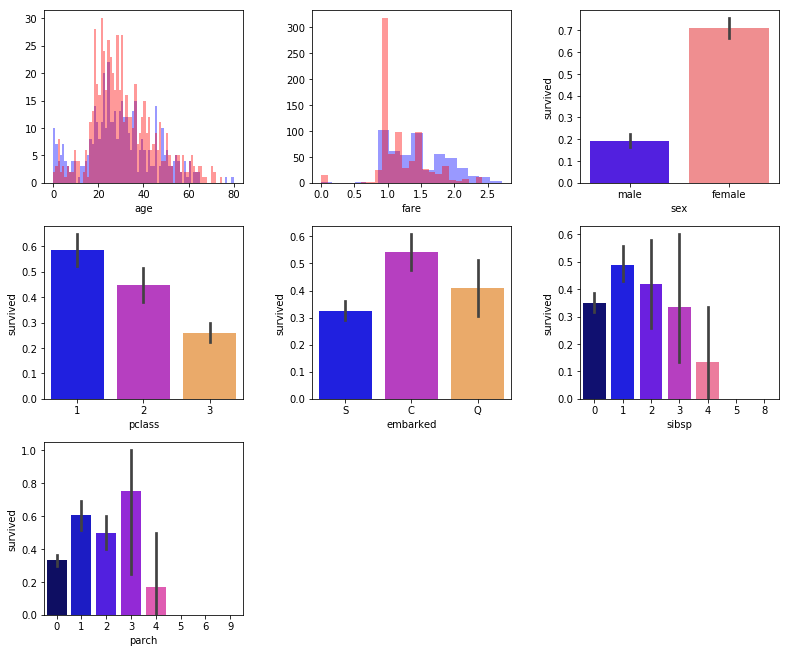

In [8]:
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='age')
plt.subplot(332)
sns.distplot(np.log10(surv['fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='fare')
plt.subplot(333)
sns.barplot('sex', 'survived', data=train_df, palette='gnuplot2')
plt.subplot(334)
sns.barplot('pclass', 'survived', data=train_df, palette='gnuplot2')
plt.subplot(335)
sns.barplot('embarked', 'survived', data=train_df, palette='gnuplot2')
plt.subplot(336)
sns.barplot('sibsp', 'survived', data=train_df, palette='gnuplot2')
plt.subplot(337)
sns.barplot('parch', 'survived', data=train_df, palette='gnuplot2')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(surv['age'].dropna()), np.median(nosurv['age'].dropna())))

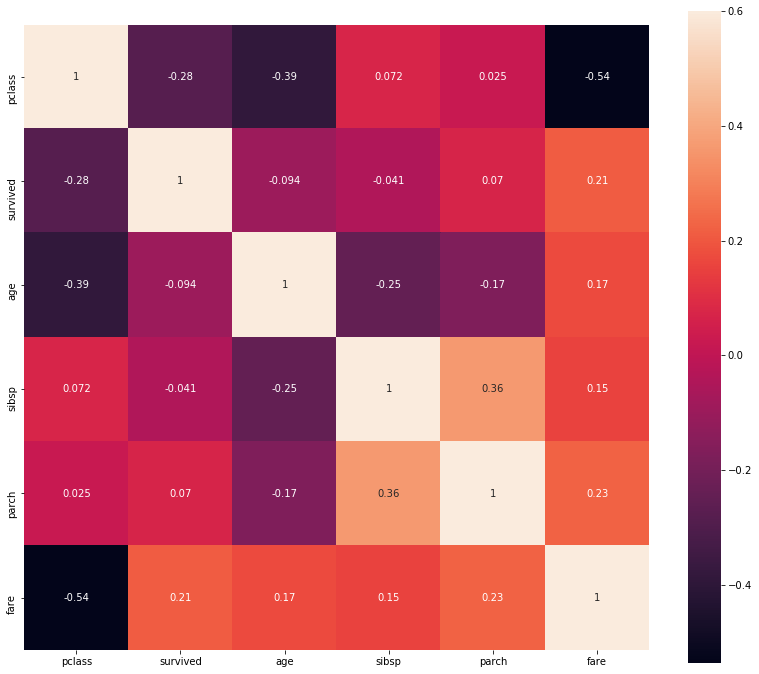

In [9]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(train_df.drop('passenger_id',axis=1).corr(), vmax=0.6, square=True, annot=True)

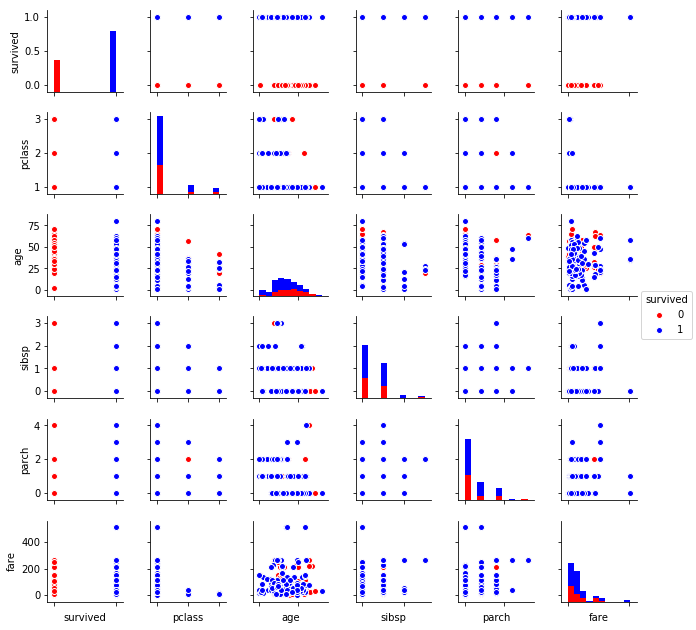

In [10]:
cols = ['survived','pclass','age','sibsp','parch','fare']
g = sns.pairplot(data=train_df.dropna(), vars=cols, size=1.5,
                 hue='survived', palette=[nosurv_col,surv_col])
g.set(xticklabels=[])

Conlusions:
1. children younger than 10-ish had a better survival rate
2. being a 1st class passenger gives you better chances of survival
3. Having 1-3 siblings/spouses/parents/children on board (SibSp = 1-2, Parch = 1-3) suggests proportionally better survival numbers than being alone (SibSp + Parch = 0) or having a large family travelling with you.
4. Embarking at "C" resulted in a higher survival rate than embarking at "S"
5. Survival chances were much lower for the cheaper cabins / Fare


- Pclass is somewhat correlated with Fare (1st class tickets would be more expensive than 3rd class ones)
- SibSp and Parch are weakly correlated (large families would have high values for both; solo travellers would have zero for both)
- Pclass already correlates with Survived in a noticeable way

## Feature engineering

In [11]:
# Title
# extract title from name
complete_df['title'] = complete_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

complete_df['title'] = complete_df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
complete_df['title'] = complete_df['title'].replace('Mlle', 'Miss')
complete_df['title'] = complete_df['title'].replace('Ms', 'Miss')
complete_df['title'] = complete_df['title'].replace('Mme', 'Mrs')

# map titles to numeric values for model
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

complete_df['title'] = complete_df['title'].map(title_mapping)
complete_df['title'] = complete_df['title'].fillna(0)

complete_df['title'] = complete_df['title'].astype("category")


In [12]:
# Sex
# make dummies, no further engineering
complete_df['sex'] = complete_df['sex'].map( {'female': 1, 'male': 0} ).astype("category")


In [13]:
# Pclass
# make dummies, no further engineering
complete_df["pclass"].replace("3rd", 3, inplace = True)
complete_df["pclass"].replace("2nd", 2, inplace = True)
complete_df["pclass"].replace("1st", 1, inplace = True)

complete_df["pclass"] = complete_df["pclass"].astype("category")

In [14]:
# Embarked
# two missing values in embarked, replace with most occuring
complete_df["embarked"] = complete_df["embarked"].fillna("S")

# dummies
complete_df["embarked"].replace("S", 3, inplace = True)
complete_df["embarked"].replace("C", 2, inplace = True)
complete_df["embarked"].replace("Q", 1, inplace = True)

complete_df['embarked'] = complete_df['embarked'].astype("category")


In [15]:
# Age
# 10% missing values, fill with mean
complete_df['age'].fillna(complete_df['age'].mean(), inplace=True)

# Child
complete_df['child'] = complete_df['age']<=10

# Young person
complete_df['young'] = (complete_df['age']<=30) | (complete_df['title'].isin(['Master','Miss','Mlle']))

# Old person
complete_df['old'] = complete_df['age']>=50

print(complete_df['child'].head())
print(complete_df['young'].head())

0    False
1     True
2    False
3    False
4    False
Name: child, dtype: bool
0    False
1     True
2    False
3     True
4     True
Name: young, dtype: bool


In [16]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
print("We know %i of %i Cabin numbers in the training data set and"
      %(len(train_df['cabin'].dropna()), len(train_df)))
print("we know %i of %i Cabin numbers in the testing data set."
      %(len(test_df['cabin'].dropna()), len(test_df)))

# Cabin known
complete_df['cabin_known'] = complete_df['cabin'].isnull() == False

We know 212 of 981 Cabin numbers in the training data set and
we know 83 of 328 Cabin numbers in the testing data set.


In [17]:
# Cabin
# determine deck
complete_df['deck'] = complete_df['cabin'].str[0]

# fill unknown cabins with "u"
complete_df['deck'] = complete_df['deck'].fillna(value='U').astype("category")

# make numerical representations
complete_df['deck'] = complete_df['deck'].map({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "U": 9}).astype("category")

In [18]:
# Fare
# fill missing Fare in with median
# fare could be imputed based on Pclass/Cabin
complete_df['fare'].fillna(complete_df['fare'].median(), inplace=True)

# make fare categories
pd.qcut(train_df['fare'], 4)

complete_df.loc[complete_df['fare'] <= 7.90, 'fare'] = 0
complete_df.loc[(complete_df['fare'] > 7.90) & (complete_df['fare'] <= 14.254), 'fare'] = 1
complete_df.loc[(complete_df['fare'] > 14.254) & (complete_df['fare'] <= 30), 'fare'] = 2
complete_df.loc[complete_df['fare'] > 30, 'fare'] = 3
complete_df['fare'] = complete_df['fare'].astype(int)


In [19]:
# Ticket
print("There are %i unique ticket numbers among the %i tickets." \
      %(train_df['ticket'].nunique(),train_df['ticket'].count()))

# type of ticket
#complete_df['ttype'] = complete_df['ticket'].str[0]

# bad ticket
#complete_df['bad_ticket'] = complete_df['ttype'].isin(['3','4','5','6','7','8','A','L','W'])

# shared ticket
complete_df['shared_ticket'] = np.where(complete_df.groupby('ticket')['name'].transform('count') > 1, 1, 0)

# ticket group
complete_df['ticket_group'] = complete_df.groupby('ticket')['name'].transform('count')


There are 744 unique ticket numbers among the 981 tickets.


In [20]:
# Family aboard
complete_df['family'] =  complete_df['parch'] + complete_df['sibsp']
complete_df['family']  = (complete_df['sibsp'] + complete_df['parch']) > 0

# alone
complete_df['alone']  = (complete_df['sibsp'] + complete_df['parch']) == 0

# family size
complete_df['large_family'] = (complete_df['sibsp']>2) | (complete_df['parch']>3)

In [21]:
# mother
complete_df['mother'] = (complete_df['age']>18) & (complete_df['parch']>0) & (complete_df['title']!= 'Miss') & (complete_df['sex'] == 1)


## Prepare for modelling

In [22]:
complete_df.head()

,passenger_id,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,...,young,old,cabin_known,deck,shared_ticket,ticket_group,family,alone,large_family,mother
0,674,3,1,"Bing, Mr. Lee",0,32.000000,0,0,1601,3,...,False,False,False,9,1,8,False,True,False,False
1,1209,3,0,"Skoog, Miss. Margit Elizabeth",1,2.000000,3,2,347088,2,...,True,False,False,9,1,6,True,False,True,False
2,367,2,0,"Chapman, Mr. Charles Henry",0,52.000000,0,0,248731,1,...,False,True,False,9,0,1,False,True,False,False
3,706,3,0,"Caram, Mrs. Joseph (Maria Elias)",1,29.881135,1,0,2689,2,...,True,False,False,9,1,2,True,False,False,False
4,1215,3,0,"Smith, Mr. Thomas",0,29.881135,0,0,384461,0,...,True,False,False,9,0,1,False,True,False,False


In [23]:
# split combined set again
train_df, test_df = train_test_split(complete_df, test_size=0.3, random_state=123)

# kaggle
#train_df = complete_df[:891]
#test_df = complete_df[891:]

# split train set in x and y
drop_cols = ['passenger_id', 'survived', 'name','ticket','cabin','age']
x_train = train_df.drop(drop_cols, axis=1)
y_train = train_df['survived']

x_test = test_df.drop(drop_cols, axis=1)
y_test = test_df['survived']

x_train.shape,x_test.shape, y_train.shape, y_test.shape

((916, 18), (393, 18), (916,), (393,))

## Modelling

In [24]:
# create logistic regression model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
#acc_log = round(logreg.score(x_train, y_train) * 100, 2)
#acc_log

acc_log = accuracy_score(y_test, y_pred)
print(acc_log)
logreg.score(x_test, y_test)

0.793893129771


0.79389312977099236

In [25]:
coeff_df = pd.DataFrame(x_train.columns)
coeff_df.columns = ['Feature']
coeff_df['Coeficient'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Coeficient', ascending=False)

,Feature,Coeficient
1,sex,2.073821
7,child,1.172244
10,cabin_known,0.480280
6,title,0.416569
8,young,0.395173
17,mother,0.352450
14,family,0.300968
13,ticket_group,0.204518
4,fare,-0.010207
11,deck,-0.029852


In [26]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negative {}'.format(tn))
print('False positive {}'.format(fp))
print('False negative {}'.format(fn))
print('True positive {}'.format(tp))

True negative 211
False positive 37
False negative 44
True positive 101


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.85      0.84       248
          1       0.73      0.70      0.71       145

avg / total       0.79      0.79      0.79       393



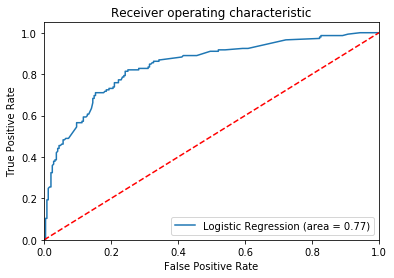

In [28]:
# roc curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [29]:
# Support vector machine
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
#acc_svc = round(svc.score(x_train, y_train) * 100, 2)
#acc_svc

acc_svc = accuracy_score(y_test, y_pred)
acc_svc

0.79389312977099236

In [30]:
# K neirest neighbor
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
#acc_knn = round(knn.score(x_train, y_train) * 100, 2)
#acc_knn

acc_knn = accuracy_score(y_test, y_pred)
acc_knn

0.70992366412213737

In [31]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)
#acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
#acc_gaussian

acc_gaussian = accuracy_score(y_test, y_pred)
acc_gaussian

0.74809160305343514

In [32]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_test)
#acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
#acc_linear_svc

acc_linear_svc = accuracy_score(y_test, y_pred)
acc_linear_svc

0.79134860050890588

In [33]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
#acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
#acc_decision_tree

acc_decision_tree = accuracy_score(y_test, y_pred)
acc_decision_tree


0.79389312977099236

In [34]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
random_forest.score(x_train, y_train)
#acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
#acc_random_forest

acc_random_forest = accuracy_score(y_test, y_pred)
acc_random_forest

0.80152671755725191

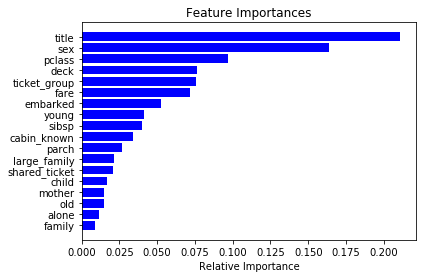

In [35]:
# feature importance
features = x_train.columns
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [36]:
# Neural network

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 18))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(x_train, y_train, batch_size = 32, epochs = 500)

Epoch 1/500
916/916 [==============================] - 0s 494us/step - loss: 0.6918 - acc: 0.6179
Epoch 2/500
916/916 [==============================] - 0s 51us/step - loss: 0.6873 - acc: 0.6124
Epoch 3/500
916/916 [==============================] - 0s 51us/step - loss: 0.6757 - acc: 0.6124
Epoch 4/500
916/916 [==============================] - 0s 51us/step - loss: 0.6508 - acc: 0.6124
Epoch 5/500
916/916 [==============================] - 0s 51us/step - loss: 0.6238 - acc: 0.6124
Epoch 6/500
916/916 [==============================] - 0s 68us/step - loss: 0.6047 - acc: 0.6124
Epoch 7/500
916/916 [==============================] - 0s 34us/step - loss: 0.5905 - acc: 0.6124
Epoch 8/500
916/916 [==============================] - 0s 34us/step - loss: 0.5762 - acc: 0.7129
Epoch 9/500
916/916 [==============================] - 0s 51us/step - loss: 0.5599 - acc: 0.7369
Epoch 10/500
916/916 [==============================] - 0s 34us/step - loss: 0.5454 - acc: 0.7511
Epoch 11/500
916/916 [======

916/916 [==============================] - 0s 34us/step - loss: 0.4118 - acc: 0.8308
Epoch 168/500
916/916 [==============================] - 0s 51us/step - loss: 0.4110 - acc: 0.8319
Epoch 169/500
916/916 [==============================] - 0s 34us/step - loss: 0.4127 - acc: 0.8253
Epoch 170/500
916/916 [==============================] - 0s 34us/step - loss: 0.4093 - acc: 0.8352
Epoch 171/500
916/916 [==============================] - 0s 34us/step - loss: 0.4143 - acc: 0.8242
Epoch 172/500
916/916 [==============================] - 0s 51us/step - loss: 0.4111 - acc: 0.8319
Epoch 173/500
916/916 [==============================] - 0s 34us/step - loss: 0.4110 - acc: 0.8286
Epoch 174/500
916/916 [==============================] - 0s 51us/step - loss: 0.4114 - acc: 0.8308
Epoch 175/500
916/916 [==============================] - 0s 51us/step - loss: 0.4115 - acc: 0.8264
Epoch 176/500
916/916 [==============================] - 0s 34us/step - loss: 0.4115 - acc: 0.8341
Epoch 177/500
916/916 [=

916/916 [==============================] - 0s 68us/step - loss: 0.3988 - acc: 0.8341
Epoch 332/500
916/916 [==============================] - 0s 34us/step - loss: 0.3979 - acc: 0.8384
Epoch 333/500
916/916 [==============================] - 0s 51us/step - loss: 0.3982 - acc: 0.8352
Epoch 334/500
916/916 [==============================] - 0s 68us/step - loss: 0.4026 - acc: 0.8275
Epoch 335/500
916/916 [==============================] - 0s 102us/step - loss: 0.4004 - acc: 0.8362
Epoch 336/500
916/916 [==============================] - 0s 85us/step - loss: 0.4005 - acc: 0.8330
Epoch 337/500
916/916 [==============================] - 0s 51us/step - loss: 0.3998 - acc: 0.8330
Epoch 338/500
916/916 [==============================] - 0s 34us/step - loss: 0.3984 - acc: 0.8352
Epoch 339/500
916/916 [==============================] - 0s 34us/step - loss: 0.4039 - acc: 0.8330
Epoch 340/500
916/916 [==============================] - 0s 51us/step - loss: 0.3983 - acc: 0.8319
Epoch 341/500
916/916 [

916/916 [==============================] - 0s 102us/step - loss: 0.3917 - acc: 0.8384
Epoch 496/500
916/916 [==============================] - 0s 68us/step - loss: 0.3904 - acc: 0.8395
Epoch 497/500
916/916 [==============================] - 0s 85us/step - loss: 0.3894 - acc: 0.8406
Epoch 498/500
916/916 [==============================] - 0s 34us/step - loss: 0.3904 - acc: 0.8373
Epoch 499/500
916/916 [==============================] - 0s 34us/step - loss: 0.3957 - acc: 0.8308
Epoch 500/500
916/916 [==============================] - 0s 51us/step - loss: 0.3895 - acc: 0.8395


In [37]:
# accuracy
y_pred = model.predict(x_test)
acc_NN = accuracy_score(y_test, y_pred>0.5)
acc_NN

0.78117048346055984

dict_keys(['loss', 'acc'])


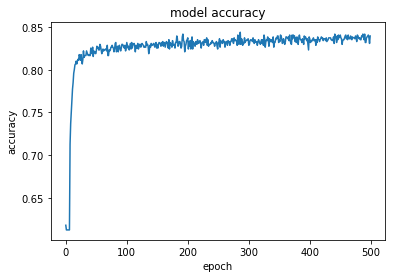

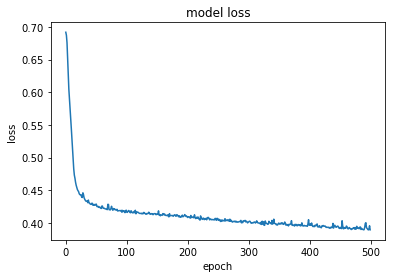

In [38]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Model evaluation

In [39]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree', "Neural network"],
    'Score': [acc_svc*100, acc_knn*100, acc_log*100, 
              acc_random_forest*100, acc_gaussian*100, acc_linear_svc*100, acc_decision_tree*100, acc_NN*100]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,80.152672
0,Support Vector Machines,79.389313
2,Logistic Regression,79.389313
6,Decision Tree,79.389313
5,Linear SVC,79.134860
7,Neural network,78.117048
4,Naive Bayes,74.809160
1,KNN,70.992366


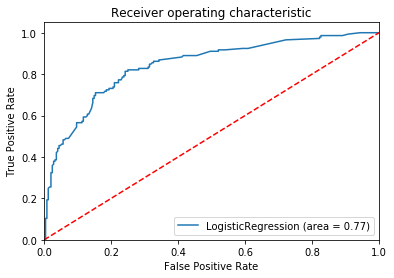

In [40]:
# roc curve

def plot_roc_curve(x_test, y_test, model):
    model_type = str(model).split('(')[0]
    model_roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (model_type, model_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
    plt.show()

# put in different models for their respective ROC-curve, doesn't work on all models
plot_roc_curve(x_test, y_test, logreg)


## make plotly equivalent
# data = []
# lw = 2
# color = 'blue'

# model_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
# # create roc
# trace = go.Scatter(x=fpr, y=tpr, 
#                        mode='lines', 
#                        line=dict(width=lw, color=color),
#                        name='ROC (area = %0.2f)' % (model_roc_auc))

# data.append(trace)

# # create diagonal
# trace = go.Scatter(x=[0, 1], y=[0, 1], 
#                    mode='lines', 
#                    line=dict(width=lw, color='red', dash='dash'),
#                    name='Luck')
# data.append(trace)

# layout = go.Layout(title='Receiver operating characteristic example',
#                    xaxis=dict(title='False Positive Rate', showgrid=False,
#                               range=[-0.05, 1.05]),
#                    yaxis=dict(title='True Positive Rate', showgrid=False,
#                               range=[-0.05, 1.05]))
# fig = go.Figure(data=data, layout=layout)
# offline.plot(fig, image='png')

In [41]:
# accuracy score

def print_accuracy(x_test, y_test, model):
    acc_score = cross_val_score(model, x_test, y_test, scoring='accuracy')
    print("Accuracy: %.3f (%.3f)" % (acc_score.mean(), acc_score.std()))

print_accuracy(x_test, y_test, logreg)

Accuracy: 0.792 (0.029)


In [42]:
# logarithmic loss  https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

def print_logloss(x_test, y_test, model):
    acc_score = cross_val_score(model, x_test, y_test, scoring='neg_log_loss')
    print("Logloss: %.3f (%.3f)" % (acc_score.mean(), acc_score.std()))

print_logloss(x_test, y_test, logreg)

Logloss: -0.474 (0.041)


[[211  37]
 [ 44 101]]


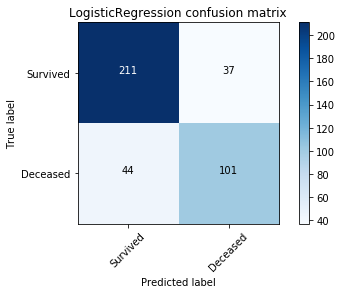

In [43]:
# confusion matrix

def print_confusion_matrix(x_test, y_test, model):
    y_pred = model.predict(x_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    print(con_matrix)
    
def plot_confusion_matrix(x_test, y_test, model):
    model_type = str(model).split('(')[0]
    outcome = ['Survived', 'Deceased']
    y_pred = model.predict(x_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure()
    plt.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('%s confusion matrix' % model_type)
    plt.colorbar()
    tick_marks = np.arange(len(outcome))
    plt.xticks(tick_marks, outcome, rotation=45)
    plt.yticks(tick_marks, outcome)
    
    fmt = 'd'
    thresh = con_matrix.max() / 2.
    for i, j in itertools.product(range(con_matrix.shape[0]), range(con_matrix.shape[1])):
        plt.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print_confusion_matrix(x_test, y_test, logreg)
plot_confusion_matrix(x_test, y_test, logreg)

In [44]:
# classification report

def print_classification_report(x_test, y_test, model):
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred)
    print(report)

print_classification_report(x_test, y_test, logreg)

             precision    recall  f1-score   support

          0       0.83      0.85      0.84       248
          1       0.73      0.70      0.71       145

avg / total       0.79      0.79      0.79       393



# feature selection

In [45]:
# https://machinelearningmastery.com/feature-selection-machine-learning-python/
# grid search?

## Export for Kaggle

In [46]:
# submission = pd.DataFrame({
#         "PassengerId": test_df["passenger_id"],
#         "Survived": y_pred.astype("int")
#     })
# submission.to_csv('titanic.csv', index=False)